Question: What were the top 3 highest rated movie genres in the last decade? 

In [1]:
from module1_util_scripts.loader import Loader
from module1_util_scripts.cleaner import DatasetCleaner
from module1_util_scripts.sqlreader import SQLReader
from module1_util_scripts.grapher import Grapher
import pandas as pd

In [2]:
def generate_df():
    
    datasets = 'zippedData/'
    configs = 'configs/'
    db = 'movies_db.sqlite'
    
    #create object instance of Loader class 'loader_obj' 
    #load all datasets to SQL database using 'load_to_sql' static method in Loader class
    datasets = Loader(datasets_folderpath=datasets, configs_folderpath=configs).read_datasets()
    threshold_config = Loader(datasets_folderpath=datasets, configs_folderpath=configs).read_configs()['thresholds']
    Loader.load_to_sql(db, datasets)
    
    #create sql query to retrive votes data from IMDB and TMDB datasets

    query = """ 
            SELECT b.tconst, b.original_title, b.start_year, b.runtime_minutes, b.genres, 
                    r.averagerating AS averagerating_imdb, r.numvotes AS numvotes_imdb, 
                    tm.vote_average AS averagerating_tmdb, tm.vote_count AS numvotes_tmdb
            FROM imdb_title_basics b
            LEFT JOIN imdb_title_ratings r
            USING (tconst)
            LEFT JOIN tmdb_movies tm
            USING (original_title)
            LEFT JOIN imdb_title_akas a
            ON a.title_id = b.tconst
            WHERE a.is_original_title = 1 ;
            """
    #query SQL database
    #clean the query result df using the clean method in the DatasetCleaner class
    df = SQLReader.read(query, db)
    df = DatasetCleaner.clean(df, threshold_config)
    for col in ['averagerating_imdb', 'numvotes_imdb', 'averagerating_tmdb', 'numvotes_tmdb']:
        df[col] = df[col].fillna(0)
    return df

In [3]:
def split_df_by_genre(df):
    
    #find all unique genres that exist in the 'genres' column
    genres = []
    for i in df['genres'].unique().tolist():
        for j in i.split(','):
            if j not in genres:
                genres.append(j)
            else:
                continue
    #create separate dataframes for each genre. note that some movies will be categorized under multiple genres,
    #for simplicity, we create a datapoint for each genre that the movie is categorized under
    #for ex, if movie A is categorized as ['Action', 'Comedy'], we will create a datapoint for 'Action' and one for 'Comedy'
    #with all other info constant, and place them in their respective genre databases
    frames = []
    for genre in genres:
        genre_df = df.loc[df['genres'].str.contains(genre)].copy()
        genre_df['genres'] = genre
        frames.append(genre_df)
    df = pd.concat(frames, axis=0)
    return df

In [4]:
def calculate_weighted_average_rating(df):
    
    #calculate the weighted average rating for each datapoint, using voting info from IMDB and TMDB
    df['total_votes'] = df['numvotes_imdb'] + df['numvotes_tmdb']
    df['weighted_average_rating'] = (((df['averagerating_imdb']*df['numvotes_imdb']) 
                                     + (df['averagerating_tmdb']*df['numvotes_tmdb']))
                                        / df['total_votes'])
    df['sum_ratings'] = df['total_votes'] * df['weighted_average_rating']
    try:
        db = 'movies_db.sqlite'
        SQLReader.read("DROP TABLE derived_ratings_df", db)
        print(f'Removing existing table in database {db}!')
    except:
        pass
    Loader.load_to_sql(db, {'derived_ratings_df': df}, remove=False)

    df = df.groupby(['start_year', 'genres'])[['total_votes', 'sum_ratings']].sum()
    df['weighted_average_rating'] = df['sum_ratings'] / df['total_votes']
    df = df.loc[df.index.get_level_values(0).isin([i for i in range(2010,2020)])].copy().unstack()
    return df

In [5]:
def generate_yoy_numvotes_df(df):
    
    #generate a df to reflect the total number of votes for each genre by year (2010-2019) 
    YoY_numvotes_df = df[['total_votes']]
    YoY_numvotes_df.columns = YoY_numvotes_df.columns.droplevel(0)
    YoY_numvotes_df = YoY_numvotes_df.T.applymap(lambda x: x if pd.notnull(x) else 0)
    YoY_numvotes_df['total_votes'] = YoY_numvotes_df.sum(axis=1)
    YoY_numvotes_df = YoY_numvotes_df.loc[YoY_numvotes_df['total_votes'] >= YoY_numvotes_df['total_votes'].describe()['50%']].copy()
    YoY_numvotes_df = YoY_numvotes_df.drop('total_votes', axis=1).T
    return YoY_numvotes_df

In [6]:
def generate_yoy_ratings_df(df, YoY_numvotes_df):
    
    #take only the genres in the top 50-percentile of total number of votes from the YoY_numvotes_df df
    #create a dataframe of weighted average ratings for the selected genres for the years 2010-2019
    #filter the dataframe by the top 5 highest rated movies 

    YoY_ratings_df = df[['weighted_average_rating']]
    YoY_ratings_df.columns = YoY_ratings_df.columns.droplevel(0)
    YoY_ratings_df = YoY_ratings_df[YoY_numvotes_df.columns.values.tolist()]
    avg_dict = {col: YoY_ratings_df[col].mean() for col in YoY_ratings_df.columns.values}
    avg_dict_sorted = sorted(avg_dict.items(), key=lambda k: k[1], reverse=True)
    top_5_genres = [elem[0] for elem in avg_dict_sorted[0:5]]
    YoY_ratings_df = YoY_ratings_df[top_5_genres]
    return YoY_ratings_df

In [7]:
def generate_ratings_chf_df(df):
    
    #for the genres in the YoY_ratings_df df (5 genres)
    #create dataframe reflecting the Year-on-Year change in ratings for the years 2010-2019
    chg = pd.DataFrame(index=YoY_ratings_df.index.values[1:], columns=YoY_ratings_df.columns.values)
    chg['prev_year'] = chg.index.values - 1
    for col in [i for i in chg.columns.values if i != 'prev_year']:
        chg[col] = chg.index.map(lambda x: YoY_ratings_df[col][x] - YoY_ratings_df[col][x-1])
    chg.drop('prev_year', axis=1, inplace=True)
    return chg

In [8]:
def plot_distributions(genres):
    
    query = f""" 
            SELECT *
            FROM derived_ratings_df 
            WHERE (genres IN {genres}
                    AND sum_ratings IS NOT NULL);
            """
    db = 'movies_db.sqlite'
    df = SQLReader.read(query, db)
    
    for genre in df['genres'].unique():
        
        print(f'Plotting distribution of all votes for {genre} movies')
        plot_df = df.loc[df['genres'] == genre].copy()
        ratings_dict = dict(zip(plot_df['total_votes'].values, plot_df['weighted_average_rating'].values))
        ratings_instances_ls = [i for elem in [[v]*int(k) for k, v in ratings_dict.items()] for i in elem]
        ratings_instances_df = pd.DataFrame({'ratings': ratings_instances_ls})
        Grapher.plot_histogram(
            'Rating', 
            'Frequency', 
            f'{genre} Ratings Frequency Distribution', 
            ratings_instances_df, 
            bins=100
        )


In [9]:
df = (generate_df()
      .pipe(split_df_by_genre)
      .pipe(calculate_weighted_average_rating)
     )
YoY_numvotes_df = generate_yoy_numvotes_df(df)
YoY_ratings_df = generate_yoy_ratings_df(df, YoY_numvotes_df)
ratings_chg_df = generate_ratings_chf_df(df)

display('YoY_numvotes_df', YoY_numvotes_df)
display('YoY_ratings_df', YoY_ratings_df)
display('ratings_chg_df', ratings_chg_df)
display('Top Rated Genres', YoY_ratings_df.T.mean(axis=1))

Reading bom.movie_gross.csv.gz with Loader
Reading imdb.name.basics.csv.gz with Loader
Reading imdb.title.akas.csv.gz with Loader
Reading imdb.title.basics.csv.gz with Loader
Reading imdb.title.crew.csv.gz with Loader
Reading imdb.title.principals.csv.gz with Loader
Reading imdb.title.ratings.csv.gz with Loader
Reading rt.movie_info.tsv.gz with Loader
Reading rt.reviews.tsv.gz with Loader
Reading tmdb.movies.csv.gz with Loader
Reading tn.movie_budgets.csv.gz with Loader
Reading thresholds.json with Loader
Removed existing database file movies_db.sqlite with Loader!
Sucessfully uploaded bom_movie_gross to movies_db.sqlite with Loader!
Sucessfully uploaded imdb_name_basics to movies_db.sqlite with Loader!
Sucessfully uploaded imdb_title_akas to movies_db.sqlite with Loader!
Sucessfully uploaded imdb_title_basics to movies_db.sqlite with Loader!
Sucessfully uploaded imdb_title_crew to movies_db.sqlite with Loader!
Sucessfully uploaded imdb_title_principals to movies_db.sqlite with Loader!

'YoY_numvotes_df'

genres,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller
start_year,,,,,,,,,,,,,,
2010,12087840.0,11461630.0,2848044.0,2294094.0,9780559.0,3832671.0,13918504.0,2420324.0,3861391.0,2617434.0,3710110.0,4505606.0,3561619.0,6626462.0
2011,12076171.0,9297206.0,1608132.0,1906198.0,10554984.0,4953214.0,16592112.0,1240623.0,4274348.0,2929897.0,3572806.0,5205449.0,5555332.0,6905988.0
2012,12565985.0,10198243.0,1919651.0,1375344.0,10216418.0,5156641.0,14501107.0,1349909.0,3549868.0,3006286.0,2523899.0,3746206.0,4618828.0,8090802.0
2013,12548774.0,11069258.0,2558233.0,4957230.0,10222144.0,8558815.0,19404963.0,533010.0,3519062.0,4115734.0,3711441.0,3971588.0,7651502.0,7087719.0
2014,17019896.0,12743036.0,1881608.0,3313628.0,10670620.0,5915851.0,18935365.0,776516.0,1500333.0,2960866.0,4589058.0,3363854.0,7466967.0,6959271.0
2015,13137875.0,13335825.0,2597435.0,5550059.0,10109181.0,6800957.0,19393733.0,773574.0,2099189.0,2614633.0,3463233.0,3441824.0,6141068.0,6112798.0
2016,12914339.0,12098217.0,2960117.0,3343573.0,9466232.0,4542507.0,18343039.0,1547529.0,4796062.0,4925195.0,3684028.0,2711630.0,4523457.0,6015494.0
2017,12119327.0,9123832.0,1371098.0,2960694.0,7826279.0,4751504.0,14670470.0,872085.0,4772474.0,4011847.0,3673298.0,1504802.0,4160478.0,5581167.0
2018,8358600.0,6666268.0,1065520.0,1876497.0,4540896.0,2202457.0,7588281.0,455889.0,1532319.0,2526084.0,1443461.0,1524427.0,4727527.0,3436362.0


'YoY_ratings_df'

genres,Biography,Animation,Sci-Fi,Adventure,Drama
start_year,,,,,
2010,7.646343,7.725505,7.709982,7.153778,6.945789
2011,7.529050,6.719566,6.857828,6.757565,7.090975
2012,7.443394,7.068264,7.071634,7.099533,7.123529
2013,7.694417,7.194666,7.094593,6.904633,7.142606
2014,7.414467,7.523321,7.249635,7.248061,7.183406
2015,7.370072,7.351695,6.969198,7.219827,7.066027
2016,7.497775,7.270891,7.065527,6.928769,7.109827
2017,7.239460,7.285357,7.091742,7.017714,7.134408
2018,7.402082,7.520976,7.010753,7.105244,6.971176


'ratings_chg_df'

,Biography,Animation,Sci-Fi,Adventure,Drama
2011,-0.117292,-1.005939,-0.852154,-0.396213,0.145186
2012,-0.085656,0.348698,0.213806,0.341968,0.032554
2013,0.251023,0.126402,0.022959,-0.194900,0.019077
2014,-0.279950,0.328655,0.155042,0.343428,0.040799
2015,-0.044396,-0.171625,-0.280437,-0.028234,-0.117378
2016,0.127704,-0.080804,0.096329,-0.291059,0.043799
2017,-0.258316,0.014465,0.026214,0.088945,0.024582
2018,0.162622,0.235620,-0.080989,0.087530,-0.163232
2019,-0.464481,-0.328063,0.642563,0.359064,-0.473396


'Top Rated Genres'

genres
Biography    7.417466
Animation    7.285316
Sci-Fi       7.177421
Adventure    7.089943
Drama        7.026552
dtype: float64

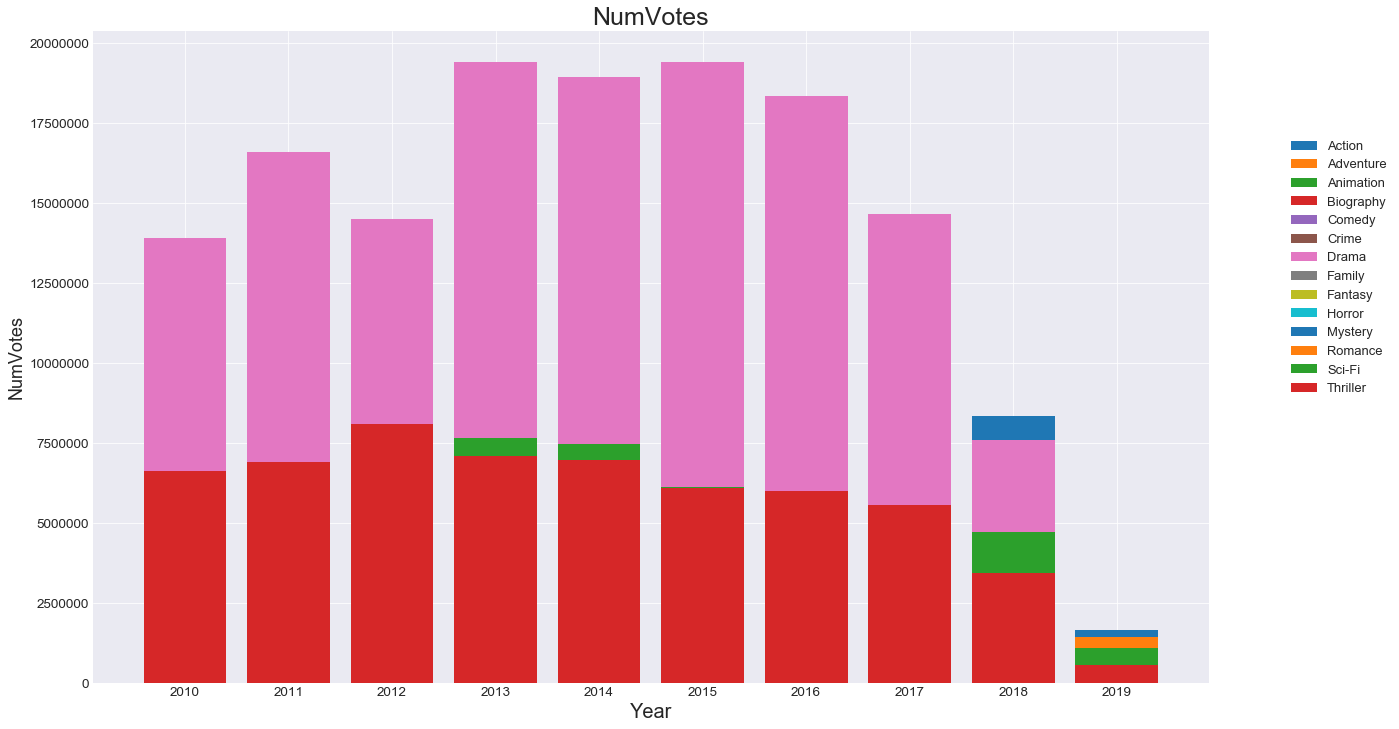

In [10]:
Grapher.plot_multiple_bar_graph('Year', 'NumVotes', 'NumVotes', YoY_numvotes_df)

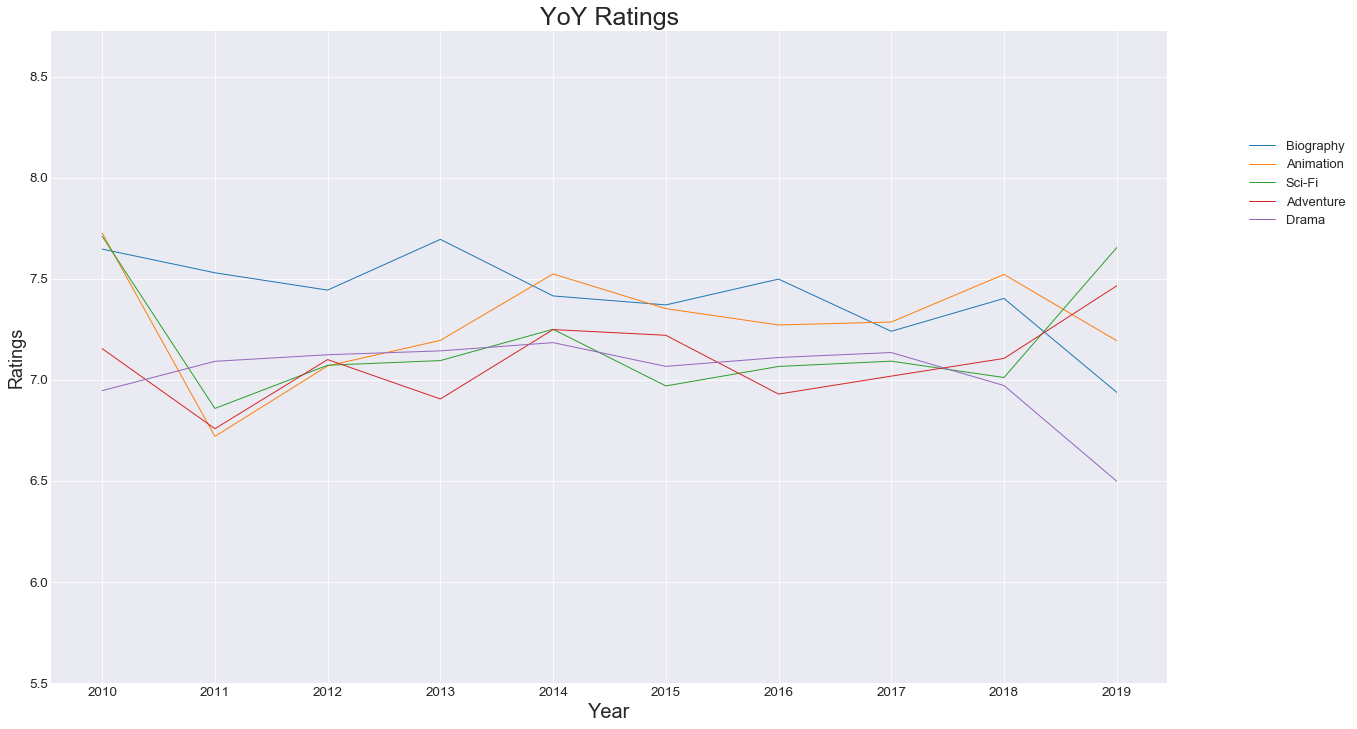

In [11]:
Grapher.plot_multiple_line_graph(
    'Year', 
    'Ratings', 
    'YoY Ratings', 
    YoY_ratings_df,
    min(YoY_ratings_df.min())-1,
    max(YoY_ratings_df.max()+1)
)

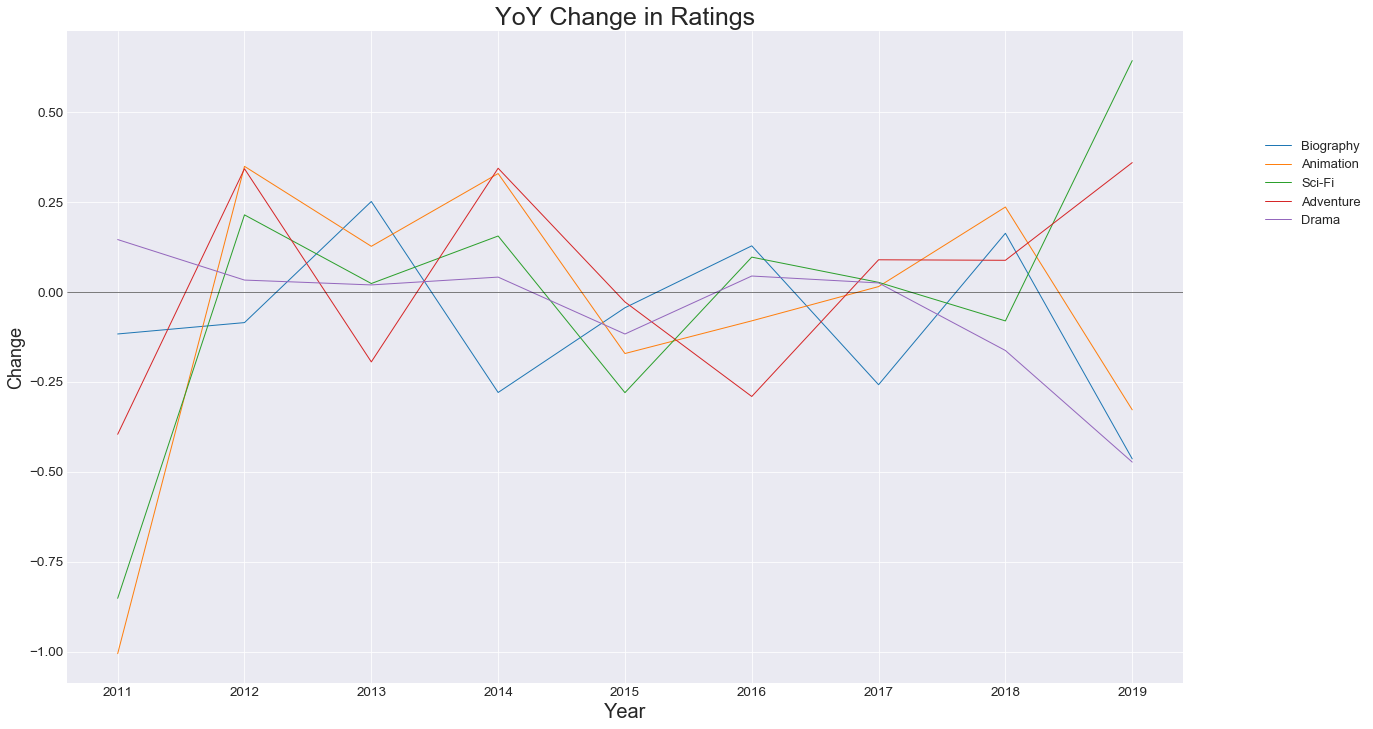

In [12]:
Grapher.plot_multiple_line_graph('Year', 'Change', 'YoY Change in Ratings', ratings_chg_df)

Processing SQL Query with SQLReader
Connecting to movies_db.sqlite with SQLReader
Sucessfully fetched query results with SQLReader
Closed connection to movies_db.sqlite with SQLReader
Plotting distribution of all votes for Biography movies


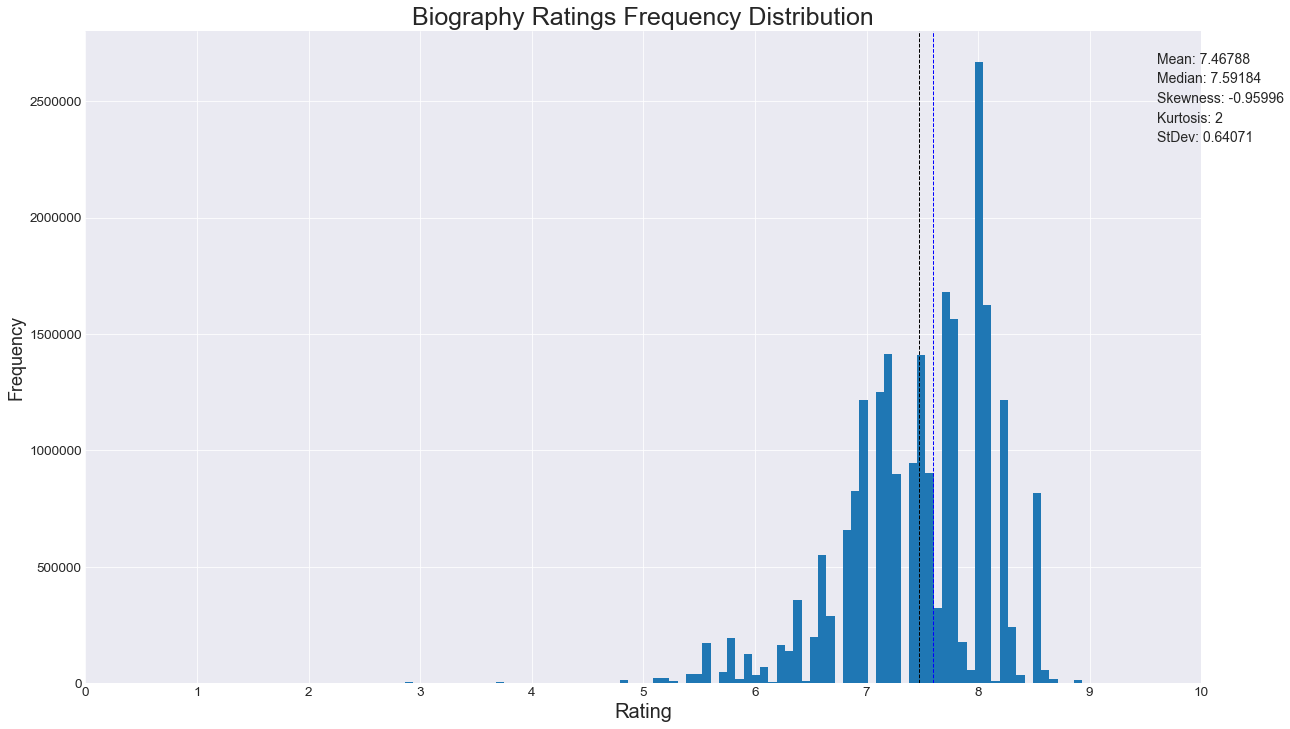

Plotting distribution of all votes for Animation movies


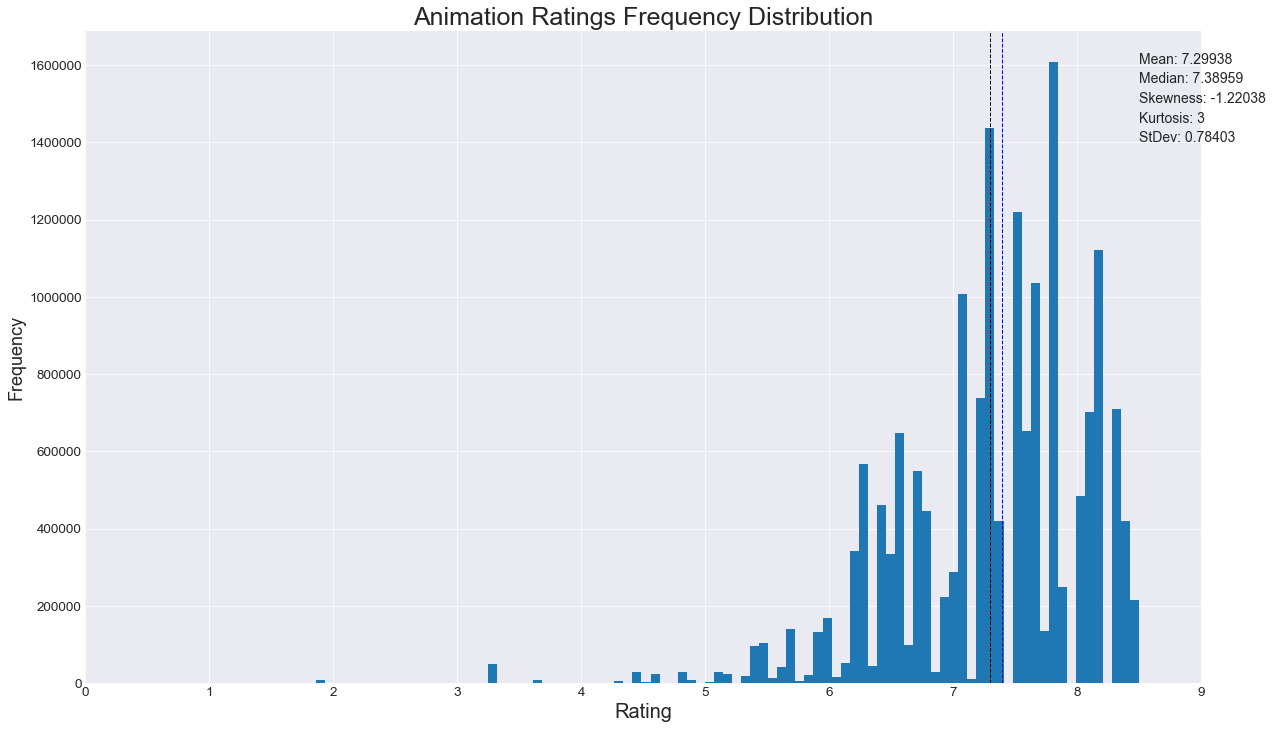

Plotting distribution of all votes for Sci-Fi movies


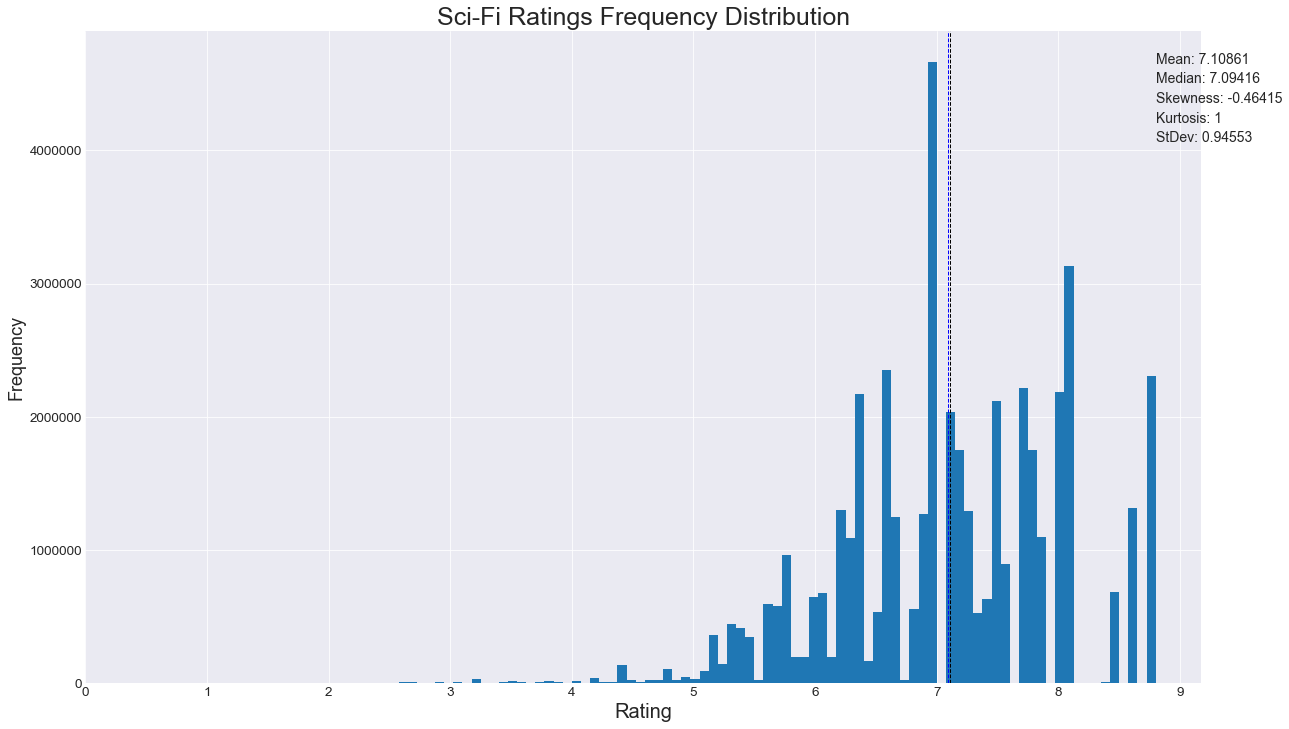

In [13]:
genres = ('Biography', 'Animation', 'Sci-Fi')
plot_distributions(genres)